# L4: Fallbacks with Branching Pipelines

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

In [1]:
import warnings
from helper import load_env

warnings.filterwarnings('ignore')
load_env()

In [2]:
from haystack import Pipeline, Document
from haystack.components.routers import ConditionalRouter
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.components.websearch.serper_dev import SerperDevWebSearch
from haystack.document_stores.in_memory import InMemoryDocumentStore

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>

### Index Documents into InMemoryDocumentStore

In [3]:
documents = [Document(content="Retrievers: Retrieves relevant documents to a user query using keyword search or semantic search."),
             Document(content="Embedders: Creates embeddings for text or documents."),
             Document(content="Generators: Use a number of model providers to generate answers or content based on a prompt"),
             Document(content="File Converters: Converts different file types like TXT, Markdown, PDF, etc. into a Haystack Document type")]

document_store = InMemoryDocumentStore()
document_store.write_documents(documents=documents)

4

### Create RAG Pipeline

In [4]:
rag_prompt_template = """
Answer the following query given the documents.
If the answer is not contained within the documents, reply with 'no_answer'
Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

In [5]:
rag = Pipeline()
rag.add_component("retriever", InMemoryBM25Retriever(document_store=document_store))
rag.add_component("prompt_builder", PromptBuilder(template=rag_prompt_template))
rag.add_component("llm", OpenAIGenerator())

rag.connect("retriever.documents", "prompt_builder.documents")
rag.connect("prompt_builder", "llm")

🚅 Components
  - retriever: InMemoryBM25Retriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

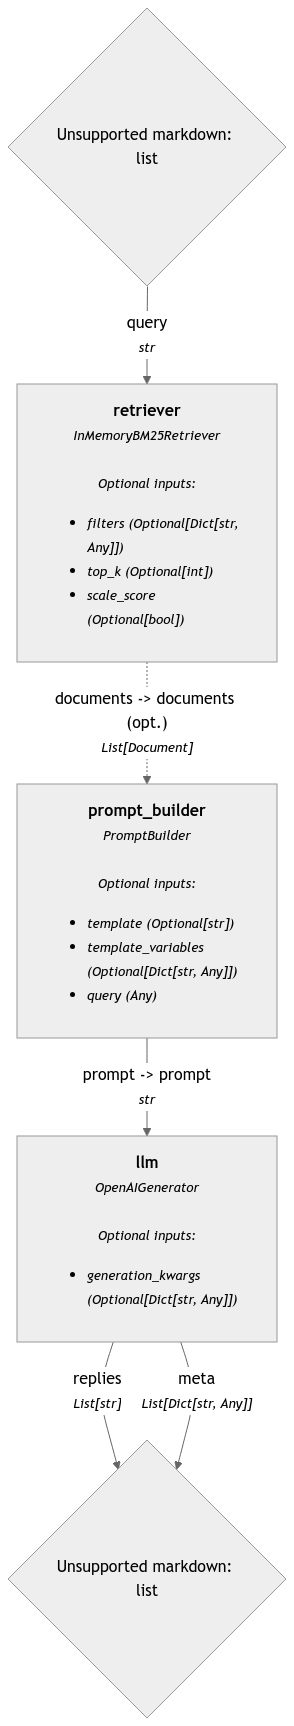

In [6]:
rag.show()

In [7]:
query = "What is a retriever for?"

rag.run({"prompt_builder":{"query": query},
         "retriever": {"query": query}})

{'llm': {'replies': ['Retrievers are used to retrieve relevant documents to a user query using keyword search or semantic search.'],
  'meta': [{'model': 'gpt-3.5-turbo-0125',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 20,
     'prompt_tokens': 117,
     'total_tokens': 137,
     'completion_tokens_details': {'reasoning_tokens': 0}}}]}}

In [8]:
query = "What Mistral components are there?"

rag.run({"prompt_builder":{"query": query},
         "retriever": {"query": query}})

{'llm': {'replies': ['no_answer'],
  'meta': [{'model': 'gpt-3.5-turbo-0125',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 2,
     'prompt_tokens': 43,
     'total_tokens': 45,
     'completion_tokens_details': {'reasoning_tokens': 0}}}]}}

### Create Conditional Routes


Now that you got the model to respond with an answer or `no_answer`, you can create pipeline branches that are activated according to this response using the [`ConditionalRouter`](https://docs.haystack.deepset.ai/docs/conditionalrouter?utm_campaign=developer-relations&utm_source=dlai) component for this.

In [9]:
routes = [
    {
        "condition": "{{'no_answer' in replies[0]|lower}}",
        "output": "{{query}}",
        "output_name": "go_to_websearch",
        "output_type": str,
    },
    {
        "condition": "{{'no_answer' not in replies[0]|lower}}",
        "output": "{{replies[0]}}",
        "output_name": "answer",
        "output_type": str,
    },
]

In [10]:
router = ConditionalRouter(routes=routes)
router.run(replies=['Geoff is my friend'], query="Who is Geoff?")

{'answer': 'Geoff is my friend'}

In [11]:
router.run(replies=['No_answer'], query="Who is Geoff?")

{'go_to_websearch': 'Who is Geoff?'}

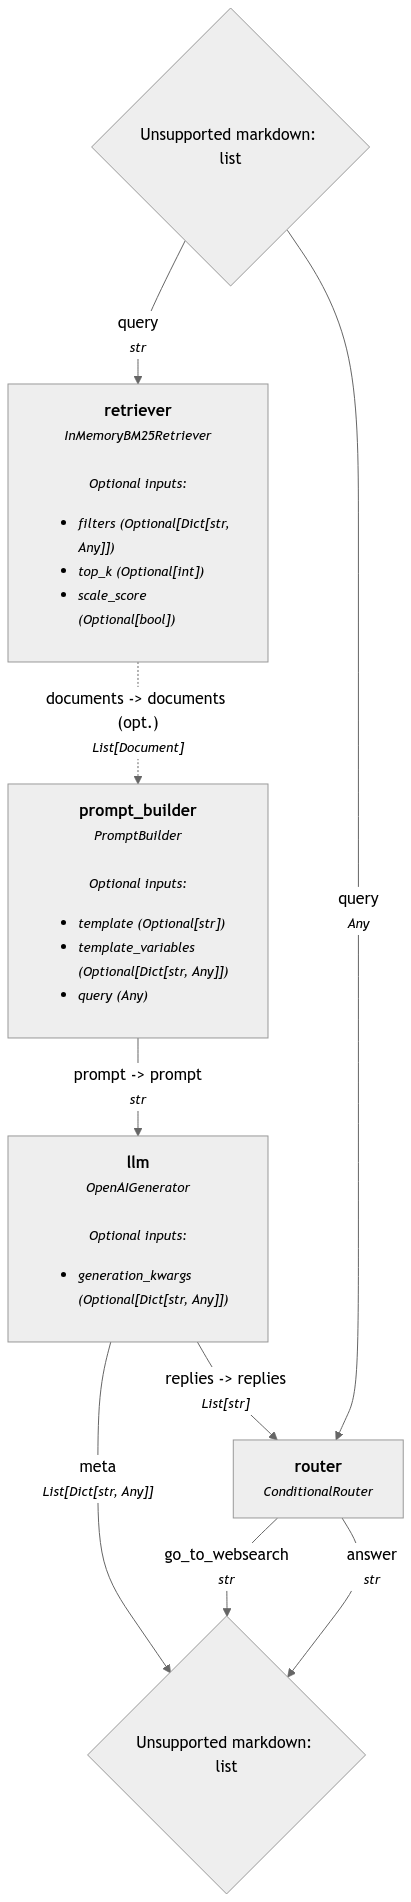

In [12]:
rag.add_component("router", ConditionalRouter(routes=routes))
rag.connect("llm.replies", "router.replies")

rag.show()

In [13]:
query = "What Mistral components does Haystack have?"

rag.run({"prompt_builder":{"query": query},
         "retriever": {"query": query},
         "router": {"query": query}})

{'llm': {'meta': [{'model': 'gpt-3.5-turbo-0125',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 2,
     'prompt_tokens': 119,
     'total_tokens': 121,
     'completion_tokens_details': {'reasoning_tokens': 0}}}]},
 'router': {'go_to_websearch': 'What Mistral components does Haystack have?'}}

### Create Websearch Branch


In [14]:
prompt_for_websearch = """
Answer the following query given the documents retrieved from the web.
Your answer should indicate that your answer was generated from websearch.
You can also reference the URLs that the answer was generated from

Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

### Build a Pipeline with Conditional Routes

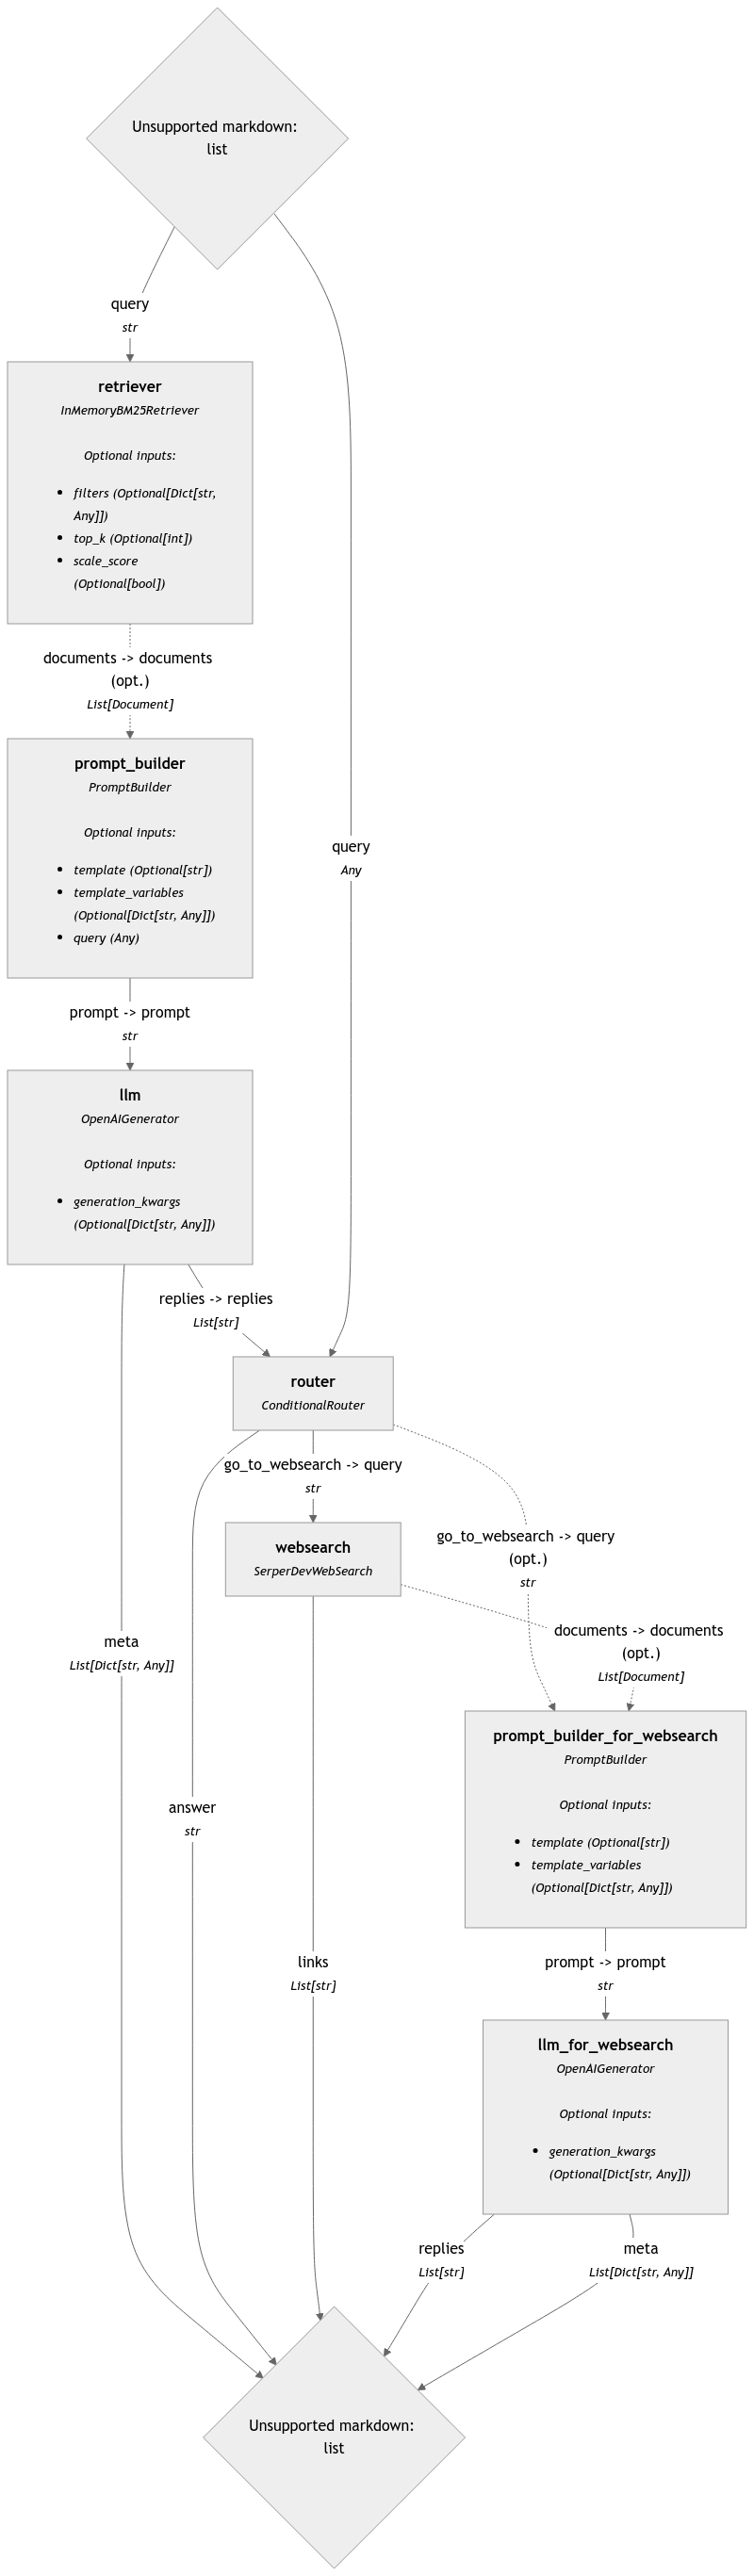

In [15]:
rag_or_websearch = Pipeline()
rag_or_websearch.add_component("retriever", InMemoryBM25Retriever(document_store=document_store))
rag_or_websearch.add_component("prompt_builder", PromptBuilder(template=rag_prompt_template))
rag_or_websearch.add_component("llm", OpenAIGenerator())
rag_or_websearch.add_component("router", ConditionalRouter(routes))
rag_or_websearch.add_component("websearch", SerperDevWebSearch())
rag_or_websearch.add_component("prompt_builder_for_websearch", PromptBuilder(template=prompt_for_websearch))
rag_or_websearch.add_component("llm_for_websearch",  OpenAIGenerator())

rag_or_websearch.connect("retriever", "prompt_builder.documents")
rag_or_websearch.connect("prompt_builder", "llm")
rag_or_websearch.connect("llm.replies", "router.replies")
rag_or_websearch.connect("router.go_to_websearch", "websearch.query")
rag_or_websearch.connect("router.go_to_websearch", "prompt_builder_for_websearch.query")
rag_or_websearch.connect("websearch.documents", "prompt_builder_for_websearch.documents")
rag_or_websearch.connect("prompt_builder_for_websearch", "llm_for_websearch")

rag_or_websearch.show()

In [16]:
query= "What is a retriever for?"

rag_or_websearch.run({"prompt_builder":{"query": query},
                      "retriever": {"query": query},
                      "router": {"query": query}})

{'llm': {'meta': [{'model': 'gpt-3.5-turbo-0125',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 20,
     'prompt_tokens': 117,
     'total_tokens': 137,
     'completion_tokens_details': {'reasoning_tokens': 0}}}]},
 'router': {'answer': 'Retrievers are used to retrieve relevant documents to a user query using keyword search or semantic search.'}}

In [17]:
query = "What Mistral components does Haystack have?"

rag_or_websearch.run({"prompt_builder":{"query": query},
                      "retriever": {"query": query},
                      "router": {"query": query}})

{'llm': {'meta': [{'model': 'gpt-3.5-turbo-0125',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 2,
     'prompt_tokens': 119,
     'total_tokens': 121,
     'completion_tokens_details': {'reasoning_tokens': 0}}}]},
 'websearch': {'links': ['https://docs.haystack.deepset.ai/reference/integrations-mistral',
   'https://github.com/deepset-ai/haystack-integrations/blob/main/integrations/mistral.md',
   'https://github.com/anakin87/mistral-haystack/blob/main/mistral_haystack.ipynb',
   'https://docs.mistral.ai/guides/rag/',
   'https://www.e2enetworks.com/blog/rag-implementation-using-mistral-7b-haystack-and-weaviate',
   'https://www.toolify.ai/ai-news/build-an-efficient-rag-model-with-haystack-and-mistral-7b-1476907',
   'https://khadkechetan.medium.com/information-extraction-with-mistral-8x7b-47111b8bd035',
   'https://www.restack.io/p/haystack-utilities-answer-cat-ai',
   'https://gitverse.ru/rnekrasov/haystack/tag/v2.0.0-beta.4/haystack/components/gene

**Next:** Try out the following questions:

- "Who is the president of the USA?"
- "How should I initialize a generator with a Mistral model with Haystack?"
- "What is the capital of France?"